# IMPORT

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import sklearn
import sys
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,LogisticRegression, LassoCV)
from sklearn.model_selection import (KFold, cross_val_score, train_test_split, cross_validate)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import (Pipeline, make_pipeline)
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import datasets

# GET DATASET

In [2]:
df_train_ori = pd.read_csv('./Admission_Predict.csv')
df_train_ori = df_train_ori.drop(['Serial No.'],axis=1)

# PLOT USING SCATTER (FOR REFERENCE)

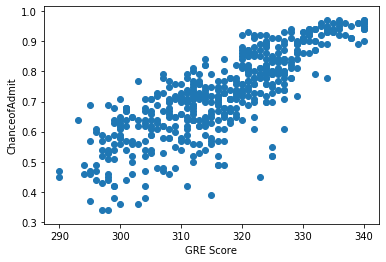

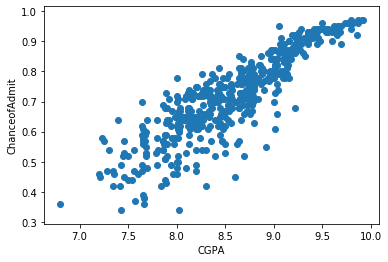

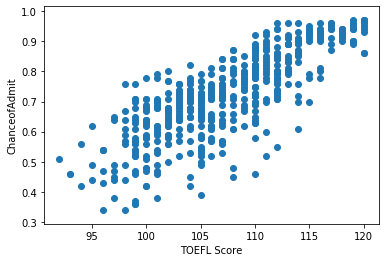

In [3]:
#Scatter plot to see if the relationships are linear. 

plt.scatter(x = df_train_ori['GRE Score'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('GRE Score')
plt.show()

plt.scatter(x = df_train_ori['CGPA'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('CGPA')
plt.show()

plt.scatter(x = df_train_ori['TOEFL Score'], y = df_train_ori['ChanceofAdmit'])
plt.ylabel('ChanceofAdmit')
plt.xlabel('TOEFL Score')
plt.show()

In [87]:
df_train_drop = df_train_ori.drop('ChanceofAdmit',1)
# If you want erase some features..
#df_train_drop = df_train_drop.drop('University Rating',1)
#df_train_drop = df_train_drop.drop('SOP',1)
#df_train_drop = df_train_drop.drop('LOR',1)
#df_train_drop = df_train_drop.drop('Research',1)
#df_train_drop = df_train_drop.drop('TOEFL Score',1)
#df_train_drop = df_train_drop.drop('GRE Score',1)

# LASSO WITH VARIOUS ALPHA

max -MSE :  -0.003962320620243807 0.0005550868030059805 116
max score :  0.8119971211750825 0.0024602398208697753 159
LR -MSE :  -0.003974416673908526
LR score :  0.8108015220863883


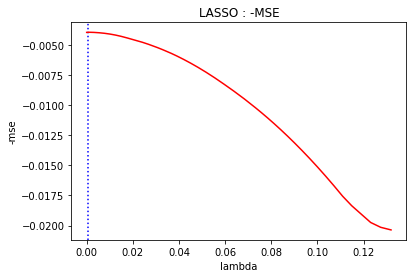

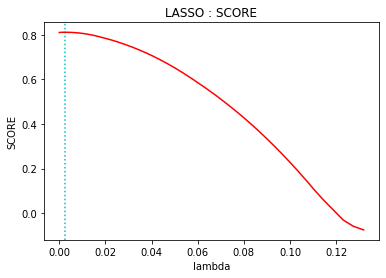

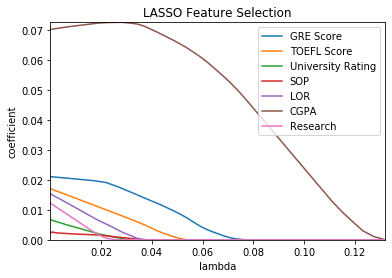

Maximum alpha where GRE Score  coefficient is nonzero :  [0.07580524]
Maximum alpha where TOEFL Score  coefficient is nonzero :  [0.05179475]
Maximum alpha where University Rating  coefficient is nonzero :  [0.03081214]
Maximum alpha where SOP  coefficient is nonzero :  [0.03538932]
Maximum alpha where LOR  coefficient is nonzero :  [0.0379269]
Maximum alpha where CGPA  coefficient is nonzero :  [0.1274275]
Maximum alpha where Research  coefficient is nonzero :  [0.02591396]


In [90]:
#df_train_drop = df_train_ori.drop('ChanceofAdmit',1)

# Preprocessing
X = df_train_drop.values
y = df_train_ori.ChanceofAdmit.values
colnames = df_train_drop.columns
kf = KFold(n_splits=5)

# Standardizing
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)


max_score=-1
max_score_alpha=0
alpha_valueArr = np.array([])
scoreArr = np.array([])
index=0
result_coef = np.ndarray(shape=(df_train_drop.shape[1],700), dtype=float)
alphas = np.logspace(-5, 1, 400)
featureArr = np.ones((df_train_drop.shape[1],1))
purescoreArr=[]
max_pure_alpha=0
max_pure_score=-1
test=False

for alpha_value in alphas:
    clf = Lasso(alpha=alpha_value)
    cv_result=cross_validate(clf,X,y,scoring='neg_mean_squared_error',cv=kf, return_estimator=True)
    scores = cv_result['test_score']
    pure=cross_val_score(clf,X,y,cv=kf)
    purescoreArr.append(np.mean(pure))
    
    # To get score for specific alpha
    '''
    if alpha_value>0.05 and test==False:
        print(alpha_value,np.mean(scores),np.mean(pure))
        test=True
    '''
    
    
    if max_score<=np.mean(scores):
        max_score=np.mean(scores)
        max_score_alpha=alpha_value 
    if max_pure_score<=np.mean(pure):
        max_pure_score=np.mean(pure)
        max_pure_alpha=alpha_value 
    alpha_valueArr = np.concatenate((alpha_valueArr, np.array([alpha_value])), axis=0)
    scoreArr = np.concatenate((scoreArr, np.array([np.mean(scores)])), axis=0)
    cv_result_es=cv_result['estimator']
    itercoef=((np.array(cv_result_es[0].coef_))+(np.array(cv_result_es[1].coef_))+(np.array(cv_result_es[2].coef_))+(np.array(cv_result_es[3].coef_))+(np.array(cv_result_es[4].coef_)))/5
    for i in range(X.shape[1]):
        result_coef[i][index]=itercoef[i]
        if itercoef[i]!=0:
            featureArr[i]=alpha_value
    index+=1
    
    if np.max(itercoef)==0:
        break
        
print('max -MSE : ',max_score, max_score_alpha, np.where(alphas==max_score_alpha)[0][0])
print('max score : ',max_pure_score, max_pure_alpha, np.where(alphas==max_pure_alpha)[0][0])

clf = LinearRegression()
scores=cross_val_score(clf,X,y,scoring='neg_mean_squared_error',cv=kf)
print('LR -MSE : ',np.mean(scores))
scores=cross_val_score(clf,X,y,cv=kf)
print('LR score : ',np.mean(scores))

plt.title('LASSO : -MSE')
plt.xlabel('lambda')
plt.ylabel('-mse')
plt.axvline(max_score_alpha, color='b', linestyle=':')
plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],scoreArr[0:(alpha_valueArr.shape[0])],'r')
plt.show()
#################
plt.title('LASSO : SCORE')
plt.xlabel('lambda')
plt.ylabel('SCORE')
plt.axvline(max_pure_alpha, color='c', linestyle=':')
plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],purescoreArr[0:(alpha_valueArr.shape[0])],'r')
plt.show()
#################

plt.title('LASSO Feature Selection')
plt.xlabel('lambda')
plt.ylabel('coefficient')
colors = ['tab:blue', 'tab:orange', 'tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','b', 'g', 'r', 'c', 'm', 'y', 'k']
for x in range(df_train_drop.shape[1]):
    plt.plot(alpha_valueArr[0:(alpha_valueArr.shape[0])],result_coef[x][0:(alpha_valueArr.shape[0])],colors[x], label=colnames[x])

plt.legend()
plt.margins(0.00001)

#plt.ylim(0,np.mean(lasso.coef_))
plt.show()

for x in range(df_train_drop.shape[1]):
    print('Maximum alpha where',colnames[x],' coefficient is nonzero : ',featureArr[x])

    
    

# DRAW FEATURES' COEF MORE BEAUTIFULLY

Computing regularization path using the LARS ...
.

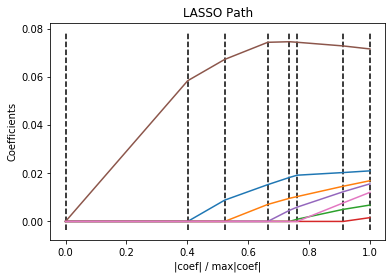

In [88]:
X = df_train_drop.values
y = df_train_ori.ChanceofAdmit.values
colnames = df_train_drop.columns
kf = KFold(n_splits=5)

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

# Code from https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
print("Computing regularization path using the LARS ...")
_, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()